In [2]:
conda install tensorflow

done
Solving environment: unsuccessful initial attempt using frozen solve. Retrying with flexible solve.
Solving environment: - ^C
unsuccessful attempt using repodata from current_repodata.json, retrying with next repodata source.

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
# import tensorflow as tf
# from tensorflow.keras import layers, Model

file_path = "/mnt/scratch/yuankeji/ibex-zonation/code/tryByOurselves/SSL/"

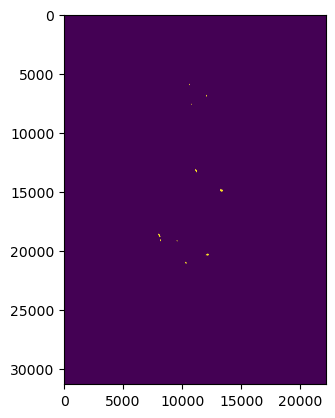

In [2]:
img = cv2.imread(file_path + "image/restored_contours.png")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (3,3),0)
ret, binary = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(binary)

In [6]:
import os
import numpy as np
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import random
from sklearn.model_selection import train_test_split
try:
    import nrrd
except ImportError:
    try:
        import pynrrd as nrrd
        print("Using pynrrd instead of nrrd")
    except ImportError:
        print("Error: Cannot import nrrd or pynrrd library")
        exit(1)

# 设置随机种子以保证可重复性
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# 解除PIL的图像大小限制
Image.MAX_IMAGE_PIXELS = None

# 定义U-Net模型
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # 输入是BCHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                                   diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


# 定义数据集类
class VesselSegmentationDataset(Dataset):
    def __init__(self, image_patches, mask_patches, transform=None):
        self.image_patches = image_patches
        self.mask_patches = mask_patches
        self.transform = transform

    def __len__(self):
        return len(self.image_patches)

    def __getitem__(self, idx):
        image = self.image_patches[idx]
        mask = self.mask_patches[idx]
        
        # 确保数据类型正确
        image = image.astype(np.float32)
        mask = mask.astype(np.float32)
        
        # 转换为张量
        image_tensor = torch.from_numpy(image).unsqueeze(0)  # 添加通道维度 (C,H,W)
        mask_tensor = torch.from_numpy(mask).unsqueeze(0)  # 添加通道维度 (C,H,W)
        
        # 应用变换（如果有）
        if self.transform:
            image_tensor = self.transform(image_tensor)
            mask_tensor = self.transform(mask_tensor)
        
        return image_tensor, mask_tensor

# 创建数据预处理和增强函数
def create_patches(image, mask, patch_size=256, stride=128):
    """从大图像和掩码中创建小块数据"""
    image_patches = []
    mask_patches = []
    h, w = image.shape[:2]
    
    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            # 提取图像小块
            image_patch = image[y:y + patch_size, x:x + patch_size]
            
            # 提取对应的掩码小块
            mask_patch = mask[y:y + patch_size, x:x + patch_size]
            
            # 只保留含有标注的小块（减少负样本的比例）
            if np.sum(mask_patch) > 100:  # 如果小块中有足够多的标注像素
                image_patches.append(image_patch)
                mask_patches.append(mask_patch)
    
    return image_patches, mask_patches

# 数据加载和预处理函数
def prepare_data(nrrd_filename, global_mask_path, patch_size=256, stride=128, test_size=0.2):
    # 加载原始图像
    print(f"Loading original NRRD file: {nrrd_filename}")
    image, header = nrrd.read(nrrd_filename)
    image = image.astype(np.float32, copy=True)
    
    # 加载全局掩码
    print(f"Loading global mask: {global_mask_path}")
    global_mask = np.array(Image.open(global_mask_path))
    if len(global_mask.shape) > 2:
        global_mask = global_mask[:, :, 0]  # 只取一个通道
    global_mask = (global_mask > 0).astype(np.float32)  # 二值化
    
    # 确保图像和掩码尺寸匹配
    if image.shape[:2] != global_mask.shape:
        print(f"Warning: Image shape {image.shape[:2]} does not match mask shape {global_mask.shape}")
        # 需要调整大小的逻辑
    
    # 如果图像是多通道的，转换为单通道
    if len(image.shape) == 3:
        # 使用均值简化为单通道
        image = np.mean(image, axis=2)
    
    # 归一化图像
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    
    # 创建小块数据
    print("Creating patches...")
    image_patches, mask_patches = create_patches(image, global_mask, patch_size, stride)
    print(f"Created {len(image_patches)} patches")
    
    # 划分训练和验证集
    patches_train, patches_val, masks_train, masks_val = train_test_split(
        image_patches, mask_patches, test_size=test_size, random_state=42
    )
    
    return patches_train, patches_val, masks_train, masks_val

# 评估函数
def dice_coefficient(y_true, y_pred):
    smooth = 1.0
    y_true_flat = y_true.view(-1)
    y_pred_flat = y_pred.view(-1)
    intersection = (y_true_flat * y_pred_flat).sum()
    return (2. * intersection + smooth) / (y_true_flat.sum() + y_pred_flat.sum() + smooth)

# 训练函数
def train_model(model, train_loader, val_loader, device, epochs=100, learning_rate=1e-4):
    # 定义损失函数和优化器
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # 用于记录训练过程
    train_losses = []
    val_losses = []
    val_dice_scores = []
    best_dice = 0.0
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        
        for images, masks in train_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            # 前向传播
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        # 计算平均训练损失
        train_loss = epoch_loss / len(train_loader)
        train_losses.append(train_loss)
        
        # 验证
        model.eval()
        val_loss = 0
        dice_score = 0
        
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                
                preds = torch.sigmoid(outputs) > 0.5
                dice_score += dice_coefficient(masks, preds).item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        avg_dice = dice_score / len(val_loader)
        val_dice_scores.append(avg_dice)
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Dice Score: {avg_dice:.4f}')
        
        # 保存最佳模型
        if avg_dice > best_dice:
            best_dice = avg_dice
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'Model saved with Dice score: {best_dice:.4f}')
    
    # 绘制训练过程
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(val_dice_scores, label='Dice Score')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Score')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.close()
    
    return model, train_losses, val_losses, val_dice_scores

# 预测函数
def predict(model, image_path, device, patch_size=256, overlap=0.5):
    """对新图像进行分割预测"""
    # 加载图像
    try:
        if image_path.endswith('.nrrd'):
            image, header = nrrd.read(image_path)
            if len(image.shape) == 3:
                image = np.mean(image, axis=2)  # 转换为单通道
        else:
            image = np.array(Image.open(image_path).convert('L'))  # 转为灰度图
    except Exception as e:
        print(f"Error loading image: {e}")
        return None
    
    # 归一化
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    
    # 创建结果掩码
    result_mask = np.zeros(image.shape, dtype=np.float32)
    count_mask = np.zeros(image.shape, dtype=np.float32)
    
    stride = int(patch_size * (1 - overlap))
    
    model.eval()
    with torch.no_grad():
        for y in range(0, image.shape[0] - patch_size + 1, stride):
            for x in range(0, image.shape[1] - patch_size + 1, stride):
                # 提取小块
                patch = image[y:y + patch_size, x:x + patch_size]
                
                # 转换为张量
                patch_tensor = torch.from_numpy(patch).float().unsqueeze(0).unsqueeze(0)
                patch_tensor = patch_tensor.to(device)
                
                # 预测
                output = model(patch_tensor)
                pred = torch.sigmoid(output).cpu().numpy().squeeze()
                
                # 将预测结果放回对应位置
                result_mask[y:y + patch_size, x:x + patch_size] += pred
                count_mask[y:y + patch_size, x:x + patch_size] += 1
    
    # 取平均值
    result_mask = np.divide(result_mask, count_mask, out=np.zeros_like(result_mask), where=count_mask != 0)
    
    # 二值化结果
    binary_mask = (result_mask > 0.5).astype(np.uint8) * 255
    
    return binary_mask

# 主函数
def main():
    # 参数设置
    NRRD_FILENAME = "./PORTAL_CENTRAL_FULL_SECTION_20250131.nrrd"
    GLOBAL_MASK_PATH = "./image/restored_contours.png"
    PATCH_SIZE = 256
    STRIDE = 128
    BATCH_SIZE = 16
    EPOCHS = 50
    LEARNING_RATE = 1e-4
    
    # 检查CUDA是否可用
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # 准备数据
    patches_train, patches_val, masks_train, masks_val = prepare_data(
        NRRD_FILENAME, 
        GLOBAL_MASK_PATH, 
        patch_size=PATCH_SIZE,
        stride=STRIDE
    )
    
    # 创建数据集和数据加载器
    train_dataset = VesselSegmentationDataset(patches_train, masks_train)
    val_dataset = VesselSegmentationDataset(patches_val, masks_val)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    # 初始化模型
    model = UNet(n_channels=1, n_classes=1, bilinear=True)
    model = model.to(device)
    
    # 训练模型
    trained_model, train_losses, val_losses, val_dice_scores = train_model(
        model, 
        train_loader, 
        val_loader, 
        device, 
        epochs=EPOCHS, 
        learning_rate=LEARNING_RATE
    )
    
    print("Training completed!")
    
    # 加载最佳模型
    model.load_state_dict(torch.load('best_model.pth'))
    
#     示例：预测新图像
    new_image_path = "./PORTAL_CENTRAL_FULL_SECTION_20250131.nrrd"
    result = predict(model, new_image_path, device, PATCH_SIZE, overlap=0.5)
    if result is not None:
        # 保存结果
        Image.fromarray(result).save('prediction_result.png')
        print("Prediction saved to 'prediction_result.png'")

if __name__ == "__main__":
    main()

Using device: cuda
Loading original NRRD file: ./PORTAL_CENTRAL_FULL_SECTION_20250131.nrrd
Loading global mask: ./image/restored_contours.png
Creating patches...
Created 95 patches
Epoch 1/50, Train Loss: 0.4600, Val Loss: 0.6571, Dice Score: 0.0000
Model saved with Dice score: 0.0000
Epoch 2/50, Train Loss: 0.3656, Val Loss: 0.6058, Dice Score: 0.0000
Epoch 3/50, Train Loss: 0.3211, Val Loss: 0.5445, Dice Score: 0.0000
Epoch 4/50, Train Loss: 0.2878, Val Loss: 0.4792, Dice Score: 0.0000
Epoch 5/50, Train Loss: 0.2943, Val Loss: 0.4369, Dice Score: 0.0000
Epoch 6/50, Train Loss: 0.2696, Val Loss: 0.4119, Dice Score: 0.0000
Epoch 7/50, Train Loss: 0.2503, Val Loss: 0.3908, Dice Score: 0.0000
Epoch 8/50, Train Loss: 0.2412, Val Loss: 0.3817, Dice Score: 0.0000
Epoch 9/50, Train Loss: 0.2324, Val Loss: 0.3787, Dice Score: 0.0000
Epoch 10/50, Train Loss: 0.2190, Val Loss: 0.3698, Dice Score: 0.0000
Epoch 11/50, Train Loss: 0.2196, Val Loss: 0.3168, Dice Score: 0.3411
Model saved with Dice 

/tmp/local/52102077/ipykernel_2709114/2553290298.py:418: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Prediction saved to 'prediction_result.png'
